A video consists of an ordered sequence of frames. Each frame contains spatial information, and the sequence of those frames contains temporal information. To model both of these aspects, we use a hybrid architecture that consists of convolutions (for spatial processing) as well as recurrent layers (for temporal processing). Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of GRU layers. This kind of hybrid architecture is popularly known as a CNN-RNN.

To build an RNN-CNN architecture for video classification, we need to process both the spatial and temporal aspects of video data. Here's a general approach:

* CNN for Feature Extraction:

    - Using trained cnn model on Deep Fake Image Classification to extract spatial features from individual frames.
    - Remove the fully connected layers to get feature maps instead of classification outputs.

* RNN for Temporal Modeling:

    - Use an RNN variant (LSTM, GRU, or Transformer-based models) to process the sequence of frame features.
    - This captures the temporal dependencies in the video.

* Final Classification:

    - Apply a dense layer with softmax activation to classify the video.

![CNN-RNN.png](attachment:715c60fc-b721-42a8-8c0a-cf826f529708.png)

In [ ]:
import gc
import tensorflow as tf

gc.collect()
tf.keras.backend.clear_session()


**Process**

**1. Videos Dataset Loading**

In [ ]:
# Base Libraries

import os
import cv2
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/My Drive/dfdc_train_part_22.zip'

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dfdc_videos')


In [ ]:
import os

video_files = os.listdir('/content/dfdc_videos')
print(video_files[:5])  # Display the first 5 files


['dfdc_train_part_22']


In [ ]:
# Looking whats inside in Dataset folder

os.listdir()[0:5]

['.config', 'dfdc_videos', 'drive', 'sample_data']

* In folder we have short videos & meta data json file containing labels along with video names.

   metadata.json

In [ ]:
meta = pd.read_json("/content/dfdc_videos/dfdc_train_part_22/metadata.json").T


In [ ]:
meta

,label,split,original
vkketnrfud.mp4,FAKE,train,ygcrqskjni.mp4
tnsaqegyqt.mp4,FAKE,train,nhkenclutb.mp4
jcwkemycdm.mp4,REAL,train,NaN
lnpsnoufkq.mp4,FAKE,train,fdzbfjfptb.mp4
rdfdbmyrqm.mp4,FAKE,train,uqqegrmuth.mp4
...,...,...,...
ltyxbyibfh.mp4,REAL,train,NaN
oxmhtrdqvf.mp4,REAL,train,NaN
hkdmxpmewr.mp4,REAL,train,NaN
kmrjhsbqqy.mp4,FAKE,train,fgrxodoqcr.mp4


In [ ]:
# Taking index column as file name

meta = meta.rename_axis('filename').reset_index()

In [ ]:
meta.head()

,filename,label,split,original
0,vkketnrfud.mp4,FAKE,train,ygcrqskjni.mp4
1,tnsaqegyqt.mp4,FAKE,train,nhkenclutb.mp4
2,jcwkemycdm.mp4,REAL,train,NaN
3,lnpsnoufkq.mp4,FAKE,train,fdzbfjfptb.mp4
4,rdfdbmyrqm.mp4,FAKE,train,uqqegrmuth.mp4


* Filename represents the name of the video which classified into fake or real
* Label is the class name for filename fake or real
* Split represents the video can be train or test
* Original is the video filename , where it modified into fake or taken as it is for the analysis

In [ ]:
# Droping original column - No Need & split column - Taking whole data as X, y

meta = meta.drop(['split','original'], axis=1)

In [ ]:
meta.head()

,filename,label
0,vkketnrfud.mp4,FAKE
1,tnsaqegyqt.mp4,FAKE
2,jcwkemycdm.mp4,REAL
3,lnpsnoufkq.mp4,FAKE
4,rdfdbmyrqm.mp4,FAKE


label
FAKE    1918
REAL     491
Name: count, dtype: int64



<Axes: xlabel='label'>

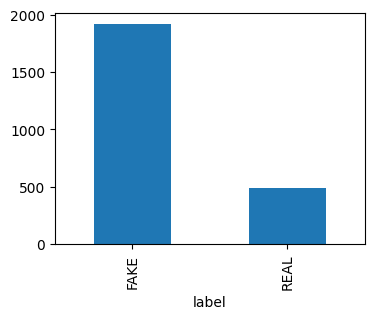

In [ ]:
# Output Distribution
import matplotlib.pyplot as plt

print(meta.label.value_counts())
print()
plt.figure(figsize=(4,3))
meta.label.value_counts().plot(kind='bar')

**2. Visualization of Videos**

In [ ]:
def play_video(video_file, folder="/content/dfdc_videos/dfdc_train_part_22/"):
    from IPython.display import HTML
    from base64 import b64encode

    path = os.path.join(folder, video_file)
    video_url = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML(f"""<video width=500 controls><source src="{data_url}" type="video/mp4"></video>""")


* **Fake Videos**

In [ ]:
fake_videos = list(meta.loc[meta.label=='FAKE'].filename)

In [ ]:
# Playing Random Video

play_video(fake_videos[8])

Output hidden; open in https://colab.research.google.com to view.

* **Real Videos**

In [ ]:
real_videos = list(meta.loc[meta.label=='REAL'].filename)

In [ ]:
# Playing Random Video

play_video(real_videos[8])

Output hidden; open in https://colab.research.google.com to view.

**3. X & y Data Preparation for Modeling**

In [ ]:
# Functions for Pre-Processing Videos

# Taking Centre of the frame where it contains features
def crop_center_square(frame):
    y, x = frame.shape[0:2] # height & width
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


# Constants -> We can increase or decrease according to analysis
FRAMES = 7
IMG_SIZE = 256

# Video loading ,Taking Frames Per Video & Pre-Processing each frame
def load_video(video, max_frames=FRAMES, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(video)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()

    # Pad if the video has fewer frames than SEQ_LEN
    while len(frames) < max_frames:
        frames.append(np.zeros((resize[0], resize[1], 3)))  # Black frame padding

    return np.array(frames)

    # Example usage
    video_path = "sample_video.mp4"
    video_data = preprocess_video(video_path)
    video_data = np.expand_dims(video_data, axis=0)  # Add batch dimension

**Videos Input(X)**

In [ ]:
X = np.array([load_video(video) for video in meta.filename])

In [ ]:
# Total Videos , Number of Frames for Video, Input Shape of Each Frame

X.shape

(2409, 7, 256, 256, 3)

In [ ]:
# Each Video Shape
X[0].shape

(7, 256, 256, 3)

**Labels for Videos (Y)**

In [ ]:
# Renaming Label Column

meta['label'].replace({'FAKE':0, 'REAL':1}, inplace=True)

In [ ]:
meta.head()

,filename,label
0,vkketnrfud.mp4,0
1,tnsaqegyqt.mp4,0
2,jcwkemycdm.mp4,1
3,lnpsnoufkq.mp4,0
4,rdfdbmyrqm.mp4,0


In [ ]:
y = np.array(meta.label)

In [ ]:
y

array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
y.shape

(2409,)

**4. Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.20,random_state=123)

**5. Model Building**

In [ ]:
# Neural Network Module

import tensorflow as tf
from tensorflow import keras

**CNN**

In [ ]:
model_path = "/content/drive/My Drive/cnn.keras"


In [ ]:
from tensorflow import keras

trained_model = keras.models.load_model(model_path)


In [ ]:
def build_feature_extractor():
   # Load model from Drive
    model_path = "/content/drive/My Drive/cnn.keras"
    trained_model = keras.models.load_model(model_path)

    # Remove the classification head (assuming it's the last layer)
    feature_extractor = keras.Model(
        inputs=trained_model.inputs,
        outputs=trained_model.layers[-4].output,  # Extract features before the final layer
        name="trained_feature_extractor"
    )

    return feature_extractor

# Instantiate the feature extractor
feature_extractor = build_feature_extractor()
feature_extractor.trainable = False# Fine Tuning
print(feature_extractor.summary())  # Output model architecture

Model: "trained_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 127, 127, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 62, 62, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 60, 60, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    29,495,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,891,992 (144.55 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 37,891,992 (144.55 MB)

None


**RNN**

In [ ]:
data_augmentation = keras.Sequential([

    keras.layers.TimeDistributed(keras.layers.RandomFlip("horizontal")),

    keras.layers.TimeDistributed(keras.layers.RandomRotation(0.1)),

    keras.layers.TimeDistributed(keras.layers.Rescaling(1./255))

])

In [ ]:
model = keras.models.Sequential([
    keras.Input(shape=(FRAMES, IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,

    keras.layers.TimeDistributed(feature_extractor),


    keras.layers.LSTM(256, return_sequences=False),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])



# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.F1Score(),
                                                                tf.keras.metrics.Precision(),
                                                                tf.keras.metrics.Recall()])
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 7, 256, 256, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 7, 2048)        │    37,891,992 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,285,337 (153.68 MB)

 Trainable params: 2,393,345 (9.13 MB)

 Non-trainable params: 37,891,992 (144.55 MB)

**6. Model Training**

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/My Drive/cnn-rnn.keras'

MC = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



In [ ]:
ytrain = np.expand_dims(ytrain, axis=-1)
ytest = np.expand_dims(ytest, axis=-1)


In [ ]:
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=45,batch_size=2, callbacks=[MC])

# Train the model

Epoch 1/45
964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7897 - f1_score: 0.3244 - loss: 0.5363 - precision: 0.1830 - recall: 0.0201
Epoch 1: val_loss improved from inf to 0.51356, saving model to /content/drive/My Drive/cnn-rnn.keras
964/964 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.7897 - f1_score: 0.3245 - loss: 0.5363 - precision: 0.1830 - recall: 0.0201 - val_accuracy: 0.8091 - val_f1_score: 0.3206 - val_loss: 0.5136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/45
964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7923 - f1_score: 0.3425 - loss: 0.5309 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss improved from 0.51356 to 0.50303, saving model to /content/drive/My Drive/cnn-rnn.keras
964/964 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7923 - f1_score: 0.3425 - loss: 0.5309 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8091 - val_f1_score: 0.3206 - val_loss: 0.5030 - val_precision: 0.0000e+00 - val_recall:

**7. Model Performance Visualization**

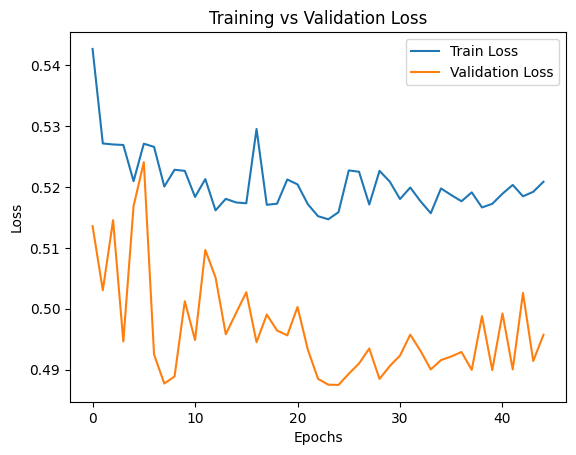

In [ ]:
# Get number of epochs from training history
epochs = range(len(model.history.history['loss']))

# Plot training and validation loss
plt.plot(epochs, model.history.history['loss'], label="Train Loss")
plt.plot(epochs, model.history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

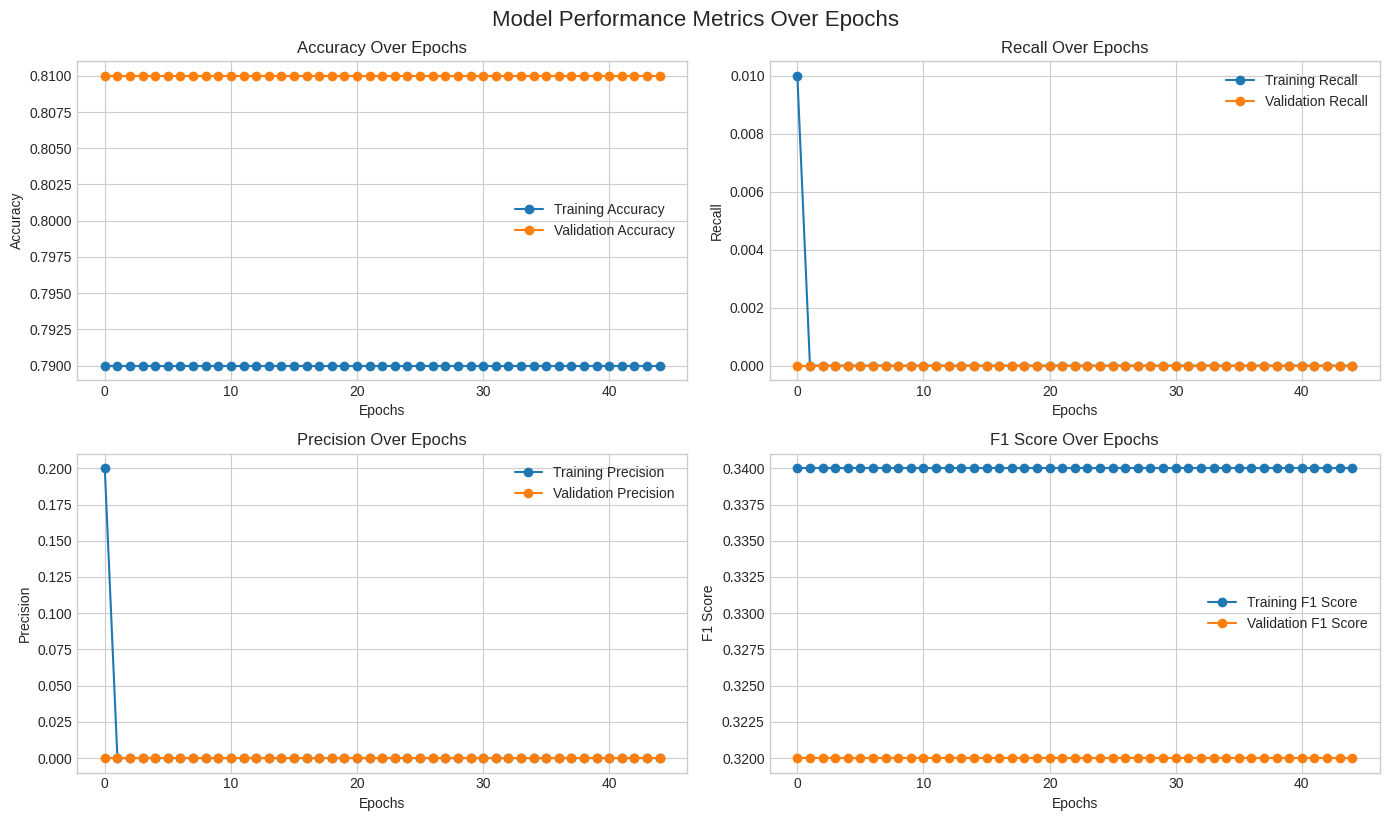

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')  # Cleaner style

epochs = np.arange(len(model.history.history['accuracy']))

# Accuracy
train_acc = [round(val, 2) for val in model.history.history['accuracy']]
val_acc = [round(val, 2) for val in model.history.history['val_accuracy']]

# Precision
train_pre = [round(val, 2) for val in model.history.history['precision']]
val_pre = [round(val, 2) for val in model.history.history['val_precision']]

# Recall
train_rec = [round(val, 2) for val in model.history.history['recall']]
val_rec = [round(val, 2) for val in model.history.history['val_recall']]

# F1 Score
train_f1 = [round(val, 2) for val in model.history.history['f1_score']]
val_f1 = [round(val, 2) for val in model.history.history['val_f1_score']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

metrics = {
    "Accuracy Over Epochs": (train_acc, val_acc, "Accuracy"),
    "Recall Over Epochs": (train_rec, val_rec, "Recall"),
    "Precision Over Epochs": (train_pre, val_pre, "Precision"),
    "F1 Score Over Epochs": (train_f1, val_f1, "F1 Score")
}

for ax, (title, (train_vals, val_vals, ylabel)) in zip(axes.flat, metrics.items()):
    ax.plot(epochs, train_vals, label=f"Training {ylabel}", marker='o')
    ax.plot(epochs, val_vals, label=f"Validation {ylabel}", marker='o')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Model Performance Metrics Over Epochs", fontsize=16, y=1.02)
plt.show()


In [ ]:
from tabulate import tabulate  # Make sure to install tabulate via pip if not already installed

# Get number of epochs
epochs = np.arange(len(model.history.history['accuracy']))

# Build a DataFrame
metrics_df = pd.DataFrame({
    "Epoch": epochs + 1,
    "Train Accuracy": model.history.history['accuracy'],
    "Val Accuracy": model.history.history['val_accuracy'],
    "Train Precision": model.history.history['precision'],
    "Val Precision": model.history.history['val_precision'],
    "Train Recall": model.history.history['recall'],
    "Val Recall": model.history.history['val_recall'],
    "Train F1 Score": model.history.history['f1_score'],
    "Val F1 Score": model.history.history['val_f1_score']
}).round(4)

# Display as a pretty table
print(tabulate(metrics_df.head(10), headers='keys', tablefmt='grid'))

+----+---------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------------+----------------+
|    |   Epoch |   Train Accuracy |   Val Accuracy |   Train Precision |   Val Precision |   Train Recall |   Val Recall |   Train F1 Score |   Val F1 Score |
+====+=========+==================+================+===================+=================+================+==============+==================+================+
|  0 |       1 |           0.7883 |         0.8091 |               0.2 |               0 |         0.0075 |            0 |           0.3431 |         0.3206 |
+----+---------+------------------+----------------+-------------------+-----------------+----------------+--------------+------------------+----------------+
|  1 |       2 |           0.7919 |         0.8091 |               0   |               0 |         0      |            0 |           0.3431 |         0.3206 |
+----+---------+------------------+-----------

**8. Prediction**

* **Loading Saved Better Performance Model from Model Check point**

In [ ]:
model = keras.models.load_model("/content/drive/My Drive/cnn-rnn.keras")

In [ ]:
video_path = "/content/drive/My Drive/dfdc_train_part_22/lshvuaztno.mp4"
video_data = load_video(video_path)
video_data = np.expand_dims(video_data, axis=0)  # Add batch dimension

In [ ]:
video_data.shape

(1, 7, 256, 256, 3)

In [ ]:
prediction = model.predict(video_data)
print("Probability:",round(prediction[0][0],2))
mapping = {0:'Fake',1:'Real'}
predicted_class = mapping[np.argmax(prediction, axis=1)[0]]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Probability: 0.19
Predicted Class: Fake
